In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score


(190, 200, 3)


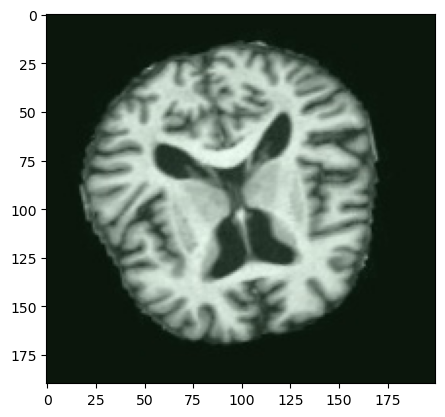

In [2]:
# loading and testing out data 
img = cv2.imread(os.path.join('Data','VeryMildDemented','2b70a7c4-b97a-4887-8e5f-85c079e7b275.jpg'))
print(img.shape)
plt.imshow(img);
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
# if you have color problem use this 

# Load Data

In [3]:
# Path to the directory containing the training images
data_dir = 'Data'

In [4]:
image_size = (50, 50)
# Image dimensions

In [5]:
# Creating an instance of the ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Rescale pixel values between 0 and 1
#     horizontal_flip=True,     # Randomly flip images horizontally
#     rotation_range=20,         # Randomly rotate images by 20 degrees
#     vertical_flip=True,        # Randomly flip images vertically
#     Flips and rotations dont really help
    validation_split=0.2       # Split 20% of data for validation
)


In [6]:
# Generating training data from the images in the specified directory
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'          # Use subset 'training' for training data
)

Found 27188 images belonging to 4 classes.


In [7]:
# Generating validation data from the images in the specified directory
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Use subset 'validation' for validation data
)

Found 6796 images belonging to 4 classes.


# Build Model

In [8]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape =(50,50,3))) # 16 filter with (3,3) pixel in size, 
# #model looks at 1 pixel at a time
# model.add(MaxPooling2D()) # max pool take the max value of the region it looks at and return that max value, 
# #default (2,2)


# model.add(Conv2D(32, (3,3), 1, activation = 'relu')) # 32 filter
# model.add(MaxPooling2D())


# model.add(Conv2D(16, (3,3), 1, activation = 'relu')) # 16 filter
# model.add(MaxPooling2D())


# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(4, activation='softmax'))



# Trying a similar architecture as VG16
model = Sequential()
model.add(Conv2D(64, (3,3), 1, activation = 'relu', input_shape =(50,50,3)))
model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

Metal device set to: Apple M2 Pro


2023-07-18 18:41:17.256328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 18:41:17.256454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
opt = Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999 ) # typical parameters

In [10]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','AUC'] )

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                    

# Visualize the Model

In [12]:
# visualizer(model, file_format='png', view=True, file_name='Conv2D_model')

# Fit Model

In [13]:
#  will use validation loss: stopping to prevent overfitting.
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)

In [14]:
# Training the model
history_model = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[trainCallback]
)


Epoch 1/50


2023-07-18 18:41:17.464969: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-18 18:41:17.756906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.4798 - auc: 0.7726

2023-07-18 18:41:36.380377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - 22s 25ms/step - loss: 1.0605 - accuracy: 0.4798 - auc: 0.7726 - val_loss: 0.8523 - val_accuracy: 0.5830 - val_auc: 0.8573
Epoch 2/50
850/850 [==============================] - 21s 24ms/step - loss: 0.7405 - accuracy: 0.6512 - auc: 0.8950 - val_loss: 0.6617 - val_accuracy: 0.6982 - val_auc: 0.9189
Epoch 3/50
850/850 [==============================] - 21s 24ms/step - loss: 0.6036 - accuracy: 0.7223 - auc: 0.9313 - val_loss: 0.5410 - val_accuracy: 0.7557 - val_auc: 0.9457
Epoch 4/50
850/850 [==============================] - 21s 25ms/step - loss: 0.4671 - accuracy: 0.7901 - auc: 0.9590 - val_loss: 0.4324 - val_accuracy: 0.8081 - val_auc: 0.9654
Epoch 5/50
850/850 [==============================] - 21s 25ms/step - loss: 0.3682 - accuracy: 0.8435 - auc: 0.9747 - val_loss: 0.3644 - val_accuracy: 0.8451 - val_auc: 0.9761
Epoch 6/50
850/850 [==============================] - 21s 25ms/step - loss: 0.2833 - accuracy: 0.8852 - auc: 0.9849 - val_loss: 0.3

# Evaluate Model

In [15]:
# Model evaluation
model.evaluate(validation_generator)

213/213 [==============================] - 3s 13ms/step - loss: 0.2690 - accuracy: 0.9316 - auc: 0.9872


[0.26902976632118225, 0.9315773844718933, 0.9872226119041443]

In [16]:
# Model prediction
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

 11/213 [>.............................] - ETA: 2s

2023-07-18 18:53:17.379501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 2s 11ms/step


<Figure size 3000x1500 with 0 Axes>

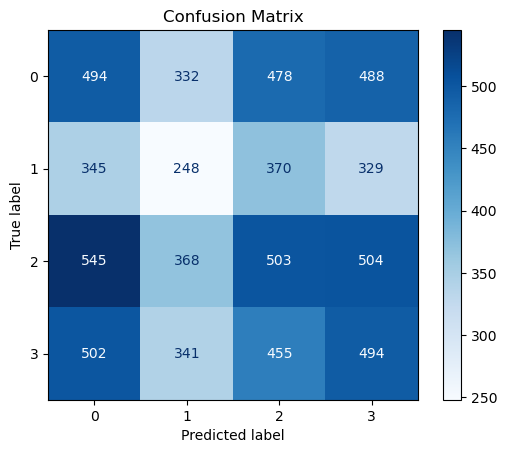

In [17]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create confusion matrix display
cm_display = ConfusionMatrixDisplay(cm)
# Plotting confusion matrix
plt.figure(figsize=(30, 15))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

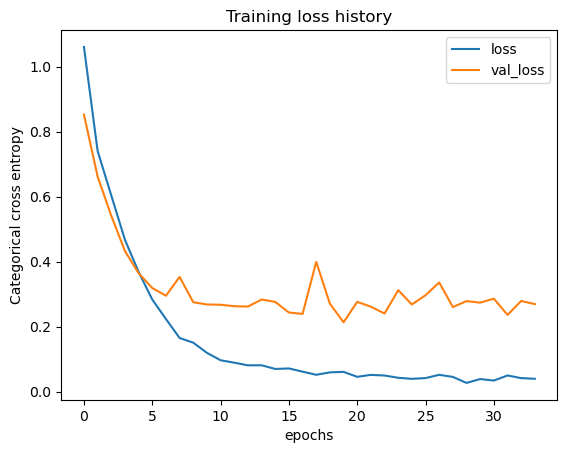

In [18]:
train_history_model = pd.DataFrame(history_model.history)
train_history_model.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_history_model[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

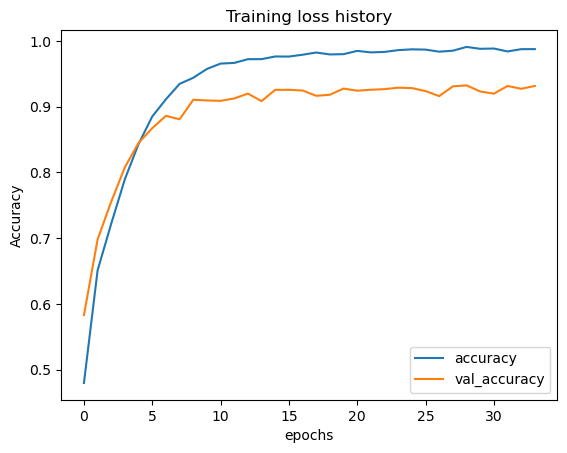

In [19]:
col_list = ['accuracy', 'val_accuracy']
train_history_model[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()